In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import embedders
import torch

In [3]:
# Torch device management
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [84]:
# Load CS PhDs

cs_dists, cs_labels = embedders.dataloaders.load("cs_phds", labels=True)

Top CC has 1025 nodes; original graph has 1025 nodes.


In [89]:
# Specify signature - useful to re-initialize the manifold here

torch.manual_seed(0)  # Not all seeds are stable - this one trains for 3000 iterations at lr=1e-2 (burn-in 1e-3)

signature = [(-1, 6)]
pm = embedders.manifolds.ProductManifold(signature=signature)
print(pm.name)

# Rescale distances
dists_rescaled = cs_dists / cs_dists.max()

# Get embedding
embedders.coordinate_learning.train_coords(
    pm,
    dists_rescaled,
    device=device,
    burn_in_iterations=100,
    training_iterations=100 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h6_cs_phds = pm.x_embed.detach().cpu().numpy()

H_1.0^6


  0%|          | 0/1000 [00:00<?, ?it/s]

In [111]:
# Compare productDT and sklearn on this dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from hyperdt.tree import HyperbolicDecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor


def cv_eval(model, name, X, y):
    # Use MSE this time
    cv = []
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv.append(mean_squared_error(y_test, y_pred))
    print(f"{name}\t{np.mean(cv):.2f} +/- {np.std(cv):.2f}")


hdt = HyperbolicDecisionTreeRegressor(max_depth=3, skip_hyperboloid_check=True)
cv_eval(hdt, "HyperDT", h6_cs_phds, np.array(cs_labels))

dt = DecisionTreeRegressor(max_depth=3)
cv_eval(dt, "DT", h6_cs_phds, np.array(cs_labels))

HyperDT	248.83 +/- 46.78
DT	252.01 +/- 62.51


In [112]:
# Specify signature - useful to re-initialize the manifold here

torch.manual_seed(0)  # Not all seeds are stable - this one trains for 3000 iterations at lr=1e-2 (burn-in 1e-3)

signature = [(-1, 2), (-1, 2), (-1, 2)]
pm2 = embedders.manifolds.ProductManifold(signature=signature)
print(pm2.name)

# Get embedding
embedders.coordinate_learning.train_coords(
    pm2,
    dists_rescaled,
    device=device,
    burn_in_iterations=100,
    training_iterations=100 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h2_3_cs_phds = pm2.x_embed.detach().cpu().numpy()

H_1.0^2 x H_1.0^2 x H_1.0^2


  0%|          | 0/1000 [00:00<?, ?it/s]

In [113]:
# What's the breakdown by subspace?

embedders.metrics.dist_component_by_manifold(pm2, pm2.x_embed)

[0.338506281375885, 0.3214499056339264, 0.34004372358322144]

In [152]:
from hyperdt.product_space_DT import ProductSpaceDTRegressor

pdt = ProductSpaceDTRegressor(max_depth=3, signature=[(s[1], s[0]) for s in signature])
cv_eval(pdt, "ProductDT", h2_3_cs_phds, np.array(cs_labels))

dt2 = DecisionTreeRegressor(max_depth=3)
cv_eval(dt2, "DT", h2_3_cs_phds, np.array(cs_labels))

ProductDT	265.17 +/- 59.38
DT	251.01 +/- 55.54


In [153]:
# Does it hold up componentwise?
# TODO: Quentin: figure out why product space DT and hyperbolic DT aren't exact matches
# TODO: Quentin: also figure out why these scores are so low

# Hyperbolic
for i in range(3):
    pdt_H = ProductSpaceDTRegressor(max_depth=3, signature=[(2, -1.0)])
    cv_eval(pdt_H, "ProductDT (H)", h2_3_cs_phds[:, pm2.man2dim[i]], np.array(cs_labels))

    hdt_H = HyperbolicDecisionTreeRegressor(max_depth=3, skip_hyperboloid_check=True)
    cv_eval(hdt_H, "HyperDT (H)", h2_3_cs_phds[:, pm2.man2dim[i]], np.array(cs_labels))

    dt_H = DecisionTreeRegressor(max_depth=3)
    cv_eval(dt_H, "DT (H)", h2_3_cs_phds[:, pm2.man2dim[i]], np.array(cs_labels))

    print()

ProductDT (H)	267.03 +/- 56.46
HyperDT (H)	257.29 +/- 53.83
DT (H)	261.25 +/- 70.21

ProductDT (H)	265.29 +/- 55.30
HyperDT (H)	264.46 +/- 60.62
DT (H)	265.90 +/- 57.98

ProductDT (H)	263.70 +/- 59.58
HyperDT (H)	278.29 +/- 65.74
DT (H)	253.76 +/- 56.11



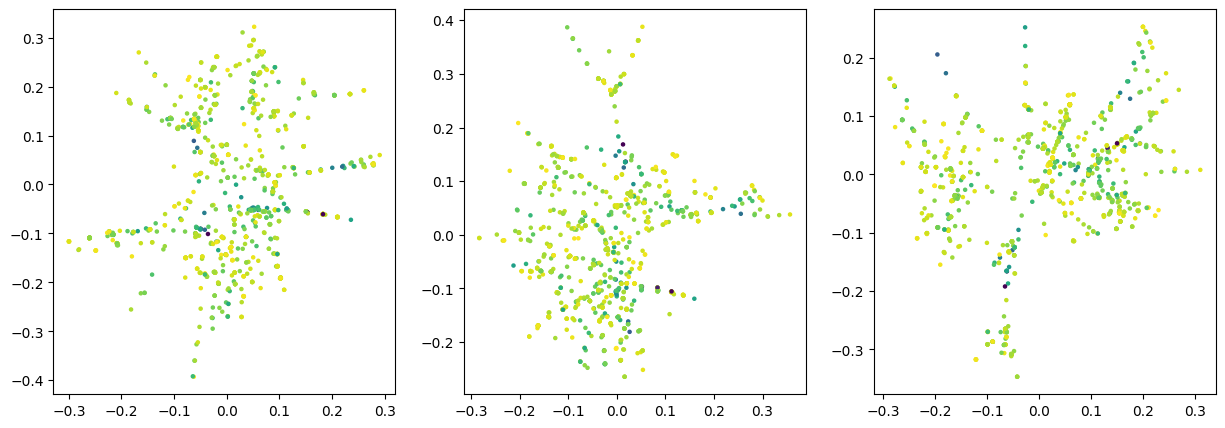

In [159]:
# Is there a remote possibility that looking at the embeddings will help?

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    poin = embedders.visualization.hyperboloid_to_poincare(h2_3_cs_phds[:, pm2.man2dim[i]])
    axs[i].scatter(poin[:, 0], poin[:, 1], c=np.array(cs_labels), cmap="viridis", s=5)